[View in Colaboratory](https://colab.research.google.com/github/gopal2812/mlblr/blob/master/captiondesenetfirstattempt.ipynb)

# Image Captioning
A  deep learning model of Image Captioning should be fast, accurate and able to identify the wide variety of objects present in the image and caption it with the text in natural laguage describing the relationship between the objects and actions.It can also be called
**Image to Text Translation**.This deep learning task combines the key concept of vision and language.We need to capture the correlation between the vision and natural language such that they map to same semantic space.

#Approaches for image captioning

**a)Linking Image and Text with Template :**

Source Paper: 
http://www.tamaraberg.com/papers/generation_cvpr11.pdf

The main idea here is to detect the objects and their attributes, parse the sentence into phrases and learn their correspondence using models like conditional randomfields(CRFs).The CRF is traditionally used for a structured prediction such as text generation.The use of CRF has limitations in generating text in a coherent manner with proper placement of prepositions.Thus it correctly predict the objects and attributes but fail at generating good descriptions.
Source Paper: 
http://www.tamaraberg.com/papers/generation_cvpr11.pdf

**b)Image Ranking: **

Source Paper:
http://papers.nips.cc/paper/4470-im2text-describing-images-using-1-million-captioned-photographs.pdf

This method relies on collecting and filtering a large data set of images from the internet to produce a novel webscale captioned photo collection. It involves the method of ranking the image and generating the caption by selection using extractive method. System Flows has been described as follows:-

1) Input query image 
2) Candidate matched images retrieved from webscale captioned collection using global image representations
3) High level information is extracted about image content including objects, attributes, actions, people, stuff, scenes, and TFIDF (text or detector based)weighting.
4) Images are re-ranked by combining all content estimates
5) Top n resulting captions.


**c)Bidirectional mapping between images and their sentence-based descriptions **

Source Paper: http://xinleic.xyz/papers/cvpr15_rnn.pdf

In this method depicts a bi-directional representation that is capable of generating both novel descriptions from images and visual representations from descriptions.It uses the
encoder, hidden layer and decoder.

1)  The main contribution of this paper is the addition of the recurrent visual hidden layer(u). 
2) The recurrent layer u attempts to reconstruct the visual features v from the previous words, i.e. ˜v ≈ v.
3) The visual hidden layer is also used by ˜wt to help in predicting
the next word.That is, the network can compare its visual memory u, which represents what it already said, with what it currently observes v to predict what to say next.
4) At the beginning of the sentence, u represents the prior probability
of the visual features. As more words are observed, the visual features are updated to reflect the words’ visual interpretation.


**d)DenseCap**

Source Paper:
https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Johnson_DenseCap_Fully_Convolutional_CVPR_2016_paper.pdf

This architecture processes an image with a single, efficient forward pass, requires
no external regions proposals, and can be trained end-to-end with a single round of optimization. The architecture is composed of a Convolutional Network, a novel
dense localization layer, and Recurrent Neural Network
language model that generates the label sequences

Steps:-
a) An input image is first processed a CNN. 
b)The Localization Layer proposes regions and smoothly extracts a batch of corresponding activations using bilinear interpolation. 
c)These regions are processed with a fully-connected recognition network
and described with an RNN language model. 
d) The model is trained end-to-end with gradient descent.


**Implementation Details:**
In current tutorial, we are going to work on the Image captioning problem with the variant of DenseCap, We solve the image captioning problem by having two model, the first called an image recognition mode and the second called a decoder. The image recognizion model describe what the image contains and output a single vector of numbers -the "thought-vector" or summary-vector, which is then input to the second RNN. This second RNN decodes this vector into the destination-text.

a) We will use the weights from the keras VGG16 modelwhich was pre-trained on the ImageNet data-set for classifying images. The VGG16 model contains a convolutional part and a fully-connected (or dense) part which is used for the image classification.
We will use some of the densenet layers in this pre-trained model, so we have to download the full mode but will train it with subset of image set in subsequent states.

b) We will use the densenet for the image part of the dense caption generation and removed the final pooling layer from it. So given an image we can get the features vector of 4096 uniformly random sampled regions which summarizes the image-contents.This will now go  as input to the GRU layer.

c) We will use this vector as the initial state of the Gated Recurrent Units (GRU). However, the internal state-size of the GRU is only 512, so we need an intermediate fully-connected (dense) layer to map the vector with 4096 elements down to a vector with only 512 elements.

d) Neural Networks cannot work directly on text-data. We use a two-step process to convert text into numbers that can be used in a neural network. The first step is to convert text-words into so-called integer-tokens. The second step is to convert integer-tokens into vectors of floating-point numbers using a so-called embedding-layer. 

e)Each image in the training-set has at least 5 captions describing the contents of the image. The neural network will be trained with batches of transfer-values for the images and sequences of integer-tokens for the captions. If we were to have matching numpy arrays for the training-set, we would either have to only use a single caption for each image and ignore the rest of this valuable data, or we would have to repeat the image transfer-values for each of the captions, which would waste a lot of memory.

f)We will now create the Recurrent Neural Network (RNN) that will be trained to map the vectors with transfer-values from the image-recognition model into sequences of integer-tokens that can be converted into text.
(1) Creation of all the layers that are not yet connected.
(2) a function that connects all these layers.

The decoder consists of 3 GRU layers whose internal state-sizes are:
state_size = 512,The embedding-layer converts integer-tokens into vectors of this length:

embedding_size = 128, This inputs transfer-values to the decoder:

transfer_values_input = Input(shape=(transfer_values_size,),
                              name='transfer_values_input')
g) We input the entire sequence of tokens to the decoder. This wastes a lot of computation because we are only interested in the last input and output. We could modify the code to return the GRU-states when calling predict() and then feeding these GRU-states as well the next time we call predict(), but it would make the code much more complicated.
        
h) Input this data to the decoder and get the predicted output.

i)Get the last predicted token as a one-hot encoded array. Note that this is not limited by softmax, but we just need the index of the largest element so it doesn't matter.

j)Convert to an integer-token and Lookup the word corresponding to this integer-token and Append the word to the output-text.
                              
 




In [1]:
!pip install keras
!pip install cache
!pip install docopt==0.6.2
!pip install Cython --install-option="--no-cython-compile"
!pip install clint
!pip install tablib
!pip install crontab
!pip install pycocotools

import sys

sys.path.append('/usr/local/bin')
!pip install coco

%matplotlib inline
!cd /usr/ && find . -name *coco*
print(sys.executable)
print(sys.path)
!which python3
import coco
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
from PIL import Image
from cache import Cache

  Running setup.py bdist_wheel for cache ... - done
  Stored in directory: /content/.cache/pip/wheels/61/8d/8d/5049f508a0d0f90705927ab33cb66df9c0673d71e6696dbc04
Successfully built cache
  Running setup.py bdist_wheel for docopt ... - done
  Stored in directory: /content/.cache/pip/wheels/9b/04/dd/7daf4150b6d9b12949298737de9431a324d4b797ffd63f526e
Successfully built docopt
/usr/local/lib/python3.6/dist-packages/pip/_internal/commands/install.py:199: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)
    100% |████████████████████████████████| 1.9MB 7.6MB/s 
Skipping bdist_wheel for Cython, due to binaries being disabled for it.
  Running setup.py install for Cython ... - \ | / - \ | / done
  Running setup.py bdist_wheel for clint ... - \ done
  Stored in directory: /content/.cache/pip/wheels/4f/e9/45/223565e5b1a4b09e12c6de6f8ba7c2c0e9127dec17cf830f83


    100% |████████████████████████████████| 71kB 2.4MB/s 
    100% |████████████████████████████████| 696kB 6.4MB/s 
    100% |████████████████████████████████| 174kB 7.8MB/s 
    100% |████████████████████████████████| 112kB 14.8MB/s 
    100% |████████████████████████████████| 102kB 8.0MB/s 
  Running setup.py bdist_wheel for tablib ... - \ done
  Stored in directory: /content/.cache/pip/wheels/ea/e4/b9/9eb46eaf91476d5dd88a5cf6f76f0884114eafe0b2ef24e2df
  Running setup.py bdist_wheel for odfpy ... - \ done
  Stored in directory: /content/.cache/pip/wheels/da/af/f6/a0b436814a73a88125b8fa82acc73ae96de511bc1faa62b7cc
  Running setup.py bdist_wheel for openpyxl ... - \ | done
  Stored in directory: /content/.cache/pip/wheels/d3/75/83/415a5bbed8366f66a87f7bd0fc28f7df6e13982960f3e5a7ab
  Running setup.py bdist_wheel for unicodecsv ... - done
  Stored in directory: /content/.cache/pip/wheels/a6/09/e9/e800279c98a0a8c94543f3de6c8a562f60e51363ed26e71283
  Running setup.py bdist

    100% |████████████████████████████████| 1.5MB 6.7MB/s 
  Running setup.py bdist_wheel for pycocotools ... - \ | / done
  Stored in directory: /content/.cache/pip/wheels/dc/e6/36/0e1ae88c868eb42d3f92181b1c9bbd0b217a7ec3da6bd62e55
Successfully built pycocotools
    100% |████████████████████████████████| 51kB 2.1MB/s 
  Running setup.py bdist_wheel for coco ... - done
  Stored in directory: /content/.cache/pip/wheels/70/4e/ba/e7599a6756eef40b3c7f89c555888951d834c5e03c27ce9657
  Running setup.py bdist_wheel for python-crontab ... - \ done
  Stored in directory: /content/.cache/pip/wheels/7d/95/06/9bdd2a919b07853cca5348120f145ee1a855cd9c96cad02e37
Successfully built coco python-crontab
./local/bin/__pycache__/coco.cpython-36.pyc
./local/bin/coco
./local/bin/coco.py
./local/lib/python3.6/dist-packages/pygments/lexers/__pycache__/_cocoa_builtins.cpython-36.pyc
./local/lib/python3.6/dist-packages/pygments/lexers/_cocoa_builtins.py
./local/lib/python3.6/dist-packages/pycocoto

In [0]:
# from tf.keras.models import Model  # This does not work!
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.python.keras.applications import VGG16,DenseNet201
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

In [3]:
tf.__version__

'1.8.0'

In [4]:
#!rm -rf coco && git clone https://github.com/pdollar/coco.git && cd coco/PythonAPI && make && make install && python setup.py install


########################################################################
#
# Functions for downloading the COCO data-set from the internet
# and loading it into memory. This data-set contains images and
# various associated data such as text-captions describing the images.
#
# http://cocodataset.org
#
# Implemented in Python 3.6
#
# Usage:
# 1) Call set_data_dir() to set the desired storage directory.
# 2) Call maybe_download_and_extract() to download the data-set
#    if it is not already located in the given data_dir.
# 3) Call load_records(train=True) and load_records(train=False)
#    to load the data-records for the training- and validation sets.
# 5) Use the returned data in your own program.
#
# Format:
# The COCO data-set contains a large number of images and various
# data for each image stored in a JSON-file.
# Functionality is provided for getting a list of image-filenames
# (but not actually loading the images) along with their associated
# data such as text-captions describing the contents of the images.
#
########################################################################
#
# This file is part of the TensorFlow Tutorials available at:
#
# https://github.com/Hvass-Labs/TensorFlow-Tutorials
#
# Published under the MIT License. See the file LICENSE for details.
#
# Copyright 2018 by Magnus Erik Hvass Pedersen
#
########################################################################
!pip install download
import json
import os
import download
from cache import Cache

########################################################################

# Directory where you want to download and save the data-set.
# Set this before you start calling any of the functions below.
# Use the function set_data_dir() to also update train_dir and val_dir.
data_dir = "data/coco/"

# Sub-directories for the training- and validation-sets.
train_dir = "data/coco/train2017"
val_dir = "data/coco/val2017"

# Base-URL for the data-sets on the internet.
data_url = "http://images.cocodataset.org/"


########################################################################
# Private helper-functions.

def _load_records(train=True):
    """
    Load the image-filenames and captions
    for either the training-set or the validation-set.
    """

    if train:
        # Training-set.
        filename = "captions_train2017.json"
    else:
        # Validation-set.
        filename = "captions_val2017.json"

    # Full path for the data-file.
    path = os.path.join(data_dir, "annotations", filename)

    # Load the file.
    with open(path, "r", encoding="utf-8") as file:
        data_raw = json.load(file)

    # Convenience variables.
    images = data_raw['images']
    annotations = data_raw['annotations']

    # Initialize the dict for holding our data.
    # The lookup-key is the image-id.
    records = dict()

    # Collect all the filenames for the images.
    for image in images:
        # Get the id and filename for this image.
        image_id = image['id']
        filename = image['file_name']

        # Initialize a new data-record.
        record = dict()

        # Set the image-filename in the data-record.
        record['filename'] = filename

        # Initialize an empty list of image-captions
        # which will be filled further below.
        record['captions'] = list()

        # Save the record using the the image-id as the lookup-key.
        records[image_id] = record

    # Collect all the captions for the images.
    for ann in annotations:
        # Get the id and caption for an image.
        image_id = ann['image_id']
        caption = ann['caption']

        # Lookup the data-record for this image-id.
        # This data-record should already exist from the loop above.
        record = records[image_id]

        # Append the current caption to the list of captions in the
        # data-record that was initialized in the loop above.
        record['captions'].append(caption)

    # Convert the records-dict to a list of tuples.
    records_list = [(key, record['filename'], record['captions'])
                    for key, record in sorted(records.items())]

    # Convert the list of tuples to separate tuples with the data.
    ids, filenames, captions = zip(*records_list)

    return ids, filenames, captions


########################################################################
# Public functions that you may call to download the data-set from
# the internet and load the data into memory.


def set_data_dir(new_data_dir):
    """
    Set the base-directory for data-files and then
    set the sub-dirs for training and validation data.
    """

    # Ensure we update the global variables.
    global data_dir, train_dir, val_dir

    data_dir = new_data_dir
    train_dir = os.path.join(new_data_dir, "train2017")
    val_dir = os.path.join(new_data_dir, "val2017")


def maybe_download_and_extract():
    """
    Download and extract the COCO data-set if the data-files don't
    already exist in data_dir.
    """

    # Filenames to download from the internet.
    filenames = ["zips/train2017.zip", "zips/val2017.zip",
                 "annotations/annotations_trainval2017.zip"]

    # Download these files.
    for filename in filenames:
        # Create the full URL for the given file.
        url = data_url + filename

        print("Downloading " + url)

        download_maybe_download_and_extract(url=url, download_dir=data_dir)


def load_records(train=True):
    """
    Load the data-records for the data-set. This returns the image ids,
    filenames and text-captions for either the training-set or validation-set.
    
    This wraps _load_records() above with a cache, so if the cache-file already
    exists then it is loaded instead of processing the original data-file.
    
    :param train:
        Bool whether to load the training-set (True) or validation-set (False).
    :return: 
        ids, filenames, captions for the images in the data-set.
    """

    if train:
        # Cache-file for the training-set data.
        cache_filename = "records_train.pkl"
    else:
        # Cache-file for the validation-set data.
        cache_filename = "records_val.pkl"

    # Path for the cache-file.
    cache_path = os.path.join(data_dir, cache_filename)

    # If the data-records already exist in a cache-file then load it,
    # otherwise call the _load_records() function and save its
    # return-values to the cache-file so it can be loaded the next time.
    records = cache(cache_path=cache_path,
                    fn=_load_records,
                    train=train)

    return records
  
  
  

    100% |████████████████████████████████| 51kB 4.1MB/s 


In [5]:
########################################################################
#
# Cache-wrapper for a function or class.
#
# Save the result of calling a function or creating an object-instance
# to harddisk. This is used to persist the data so it can be reloaded
# very quickly and easily.
#
# Implemented in Python 3.5
#
########################################################################
#
# This file is part of the TensorFlow Tutorials available at:
#
# https://github.com/Hvass-Labs/TensorFlow-Tutorials
#
# Published under the MIT License. See the file LICENSE for details.
#
# Copyright 2016 by Magnus Erik Hvass Pedersen
#
########################################################################

import os
import pickle
import numpy as np

########################################################################


def cache(cache_path, fn, *args, **kwargs):
    """
    Cache-wrapper for a function or class. If the cache-file exists
    then the data is reloaded and returned, otherwise the function
    is called and the result is saved to cache. The fn-argument can
    also be a class instead, in which case an object-instance is
    created and saved to the cache-file.
    :param cache_path:
        File-path for the cache-file.
    :param fn:
        Function or class to be called.
    :param args:
        Arguments to the function or class-init.
    :param kwargs:
        Keyword arguments to the function or class-init.
    :return:
        The result of calling the function or creating the object-instance.
    """

    # If the cache-file exists.
    if os.path.exists(cache_path):
        # Load the cached data from the file.
        with open(cache_path, mode='rb') as file:
            obj = pickle.load(file)

        print("- Data loaded from cache-file: " + cache_path)
    else:
        # The cache-file does not exist.

        # Call the function / class-init with the supplied arguments.
        obj = fn(*args, **kwargs)

        # Save the data to a cache-file.
        with open(cache_path, mode='wb') as file:
            pickle.dump(obj, file)

        print("- Data saved to cache-file: " + cache_path)

    return obj


########################################################################


def convert_numpy2pickle(in_path, out_path):
    """
    Convert a numpy-file to pickle-file.
    The first version of the cache-function used numpy for saving the data.
    Instead of re-calculating all the data, you can just convert the
    cache-file using this function.
    :param in_path:
        Input file in numpy-format written using numpy.save().
    :param out_path:
        Output file written as a pickle-file.
    :return:
        Nothing.
    """

    # Load the data using numpy.
    data = np.load(in_path)

    # Save the data using pickle.
    with open(out_path, mode='wb') as file:
        pickle.dump(data, file)


########################################################################

if __name__ == '__main__':
    # This is a short example of using a cache-file.

    # This is the function that will only get called if the result
    # is not already saved in the cache-file. This would normally
    # be a function that takes a long time to compute, or if you
    # need persistent data for some other reason.
    def expensive_function(a, b):
        return a * b

    print('Computing expensive_function() ...')

    # Either load the result from a cache-file if it already exists,
    # otherwise calculate expensive_function(a=123, b=456) and
    # save the result to the cache-file for next time.
    result = cache(cache_path='cache_expensive_function.pkl',
                   fn=expensive_function, a=123, b=456)

    print('result =', result)

    # Newline.
    print()

    # This is another example which saves an object to a cache-file.

    # We want to cache an object-instance of this class.
    # The motivation is to do an expensive computation only once,
    # or if we need to persist the data for some other reason.
    class ExpensiveClass:
        def __init__(self, c, d):
            self.c = c
            self.d = d
            self.result = c * d

        def print_result(self):
            print('c =', self.c)
            print('d =', self.d)
            print('result = c * d =', self.result)

    print('Creating object from ExpensiveClass() ...')

    # Either load the object from a cache-file if it already exists,
    # otherwise make an object-instance ExpensiveClass(c=123, d=456)
    # and save the object to the cache-file for the next time.
    obj = cache(cache_path='cache_ExpensiveClass.pkl',
                fn=ExpensiveClass, c=123, d=456)

    obj.print_result()

########################################################################

Computing expensive_function() ...
- Data saved to cache-file: cache_expensive_function.pkl
result = 56088

Creating object from ExpensiveClass() ...
- Data saved to cache-file: cache_ExpensiveClass.pkl
c = 123
d = 456
result = c * d = 56088


In [6]:
########################################################################

import sys
import os
import urllib.request
import tarfile
import zipfile

########################################################################


def _print_download_progress(count, block_size, total_size):
    """
    Function used for printing the download progress.
    Used as a call-back function in maybe_download_and_extract().
    """

    # Percentage completion.
    pct_complete = float(count * block_size) / total_size

    # Status-message. Note the \r which means the line should overwrite itself.
    msg = "\r- Download progress: {0:.1%}".format(pct_complete)

    # Print it.
    sys.stdout.write(msg)
    sys.stdout.flush()


########################################################################


def download_maybe_download_and_extract(url, download_dir):
    """
    Download and extract the data if it doesn't already exist.
    Assumes the url is a tar-ball file.
    :param url:
        Internet URL for the tar-file to download.
        Example: "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    :param download_dir:
        Directory where the downloaded file is saved.
        Example: "data/CIFAR-10/"
    :return:
        Nothing.
    """

    # Filename for saving the file downloaded from the internet.
    # Use the filename from the URL and add it to the download_dir.
    filename = url.split('/')[-1]
    file_path = os.path.join(download_dir, filename)

    # Check if the file already exists.
    # If it exists then we assume it has also been extracted,
    # otherwise we need to download and extract it now.
    if not os.path.exists(file_path):
        # Check if the download directory exists, otherwise create it.
        if not os.path.exists(download_dir):
            os.makedirs(download_dir)

        # Download the file from the internet.
        file_path, _ = urllib.request.urlretrieve(url=url,
                                                  filename=file_path,
                                                  reporthook=_print_download_progress)

        print()
        print("Download finished. Extracting files.")

        if file_path.endswith(".zip"):
            # Unpack the zip-file.
            zipfile.ZipFile(file=file_path, mode="r").extractall(download_dir)
        elif file_path.endswith((".tar.gz", ".tgz")):
            # Unpack the tar-ball.
            tarfile.open(name=file_path, mode="r:gz").extractall(download_dir)

        print("Done.")
    else:
        print("Data has apparently already been downloaded and unpacked.")


########################################################################




maybe_download_and_extract()

- Download progress: 100.0%


Download finished. Extracting files.
Done.
- Download progress: 0.8%

- Download progress: 97.5%

Done.
- Download progress: 2.8%

- Download progress: 100.0%
Download finished. Extracting files.
Done.


In [7]:
_, filenames_train, captions_train = load_records(train=True)
num_images_train = len(filenames_train)
num_images_train

_, filenames_val, captions_val = load_records(train=False)

def load_image(path, size=None):
    """
    Load the image from the given file-path and resize it
    to the given size if not None.
    """

    # Load the image using PIL.
    img = Image.open(path)

    # Resize image if desired.
    if not size is None:
        img = img.resize(size=size, resample=Image.LANCZOS)

    # Convert image to numpy array.
    img = np.array(img)

    # Scale image-pixels so they fall between 0.0 and 1.0
    img = img / 255.0

    # Convert 2-dim gray-scale array to 3-dim RGB array.
    if (len(img.shape) == 2):
        img = np.repeat(img[:, :, np.newaxis], 3, axis=2)

    return img
  




- Data saved to cache-file: data/coco/records_train.pkl
- Data saved to cache-file: data/coco/records_val.pkl


In [0]:
def show_image(idx, train):
    """
    Load and plot an image from the training- or validation-set
    with the given index.
    """

    if train:
        # Use an image from the training-set.
        dir = train_dir
        filename = filenames_train[idx]
        captions = captions_train[idx]
    else:
        # Use an image from the validation-set.
        dir = val_dir
        filename = filenames_val[idx]
        captions = captions_val[idx]

    # Path for the image-file.
    path = os.path.join(dir, filename)

    # Print the captions for this image.
    for caption in captions:
        print(caption)
    
    # Load the image and plot it.
    img = load_image(path)
    plt.imshow(img)
    plt.show()
    
#!ls -l data/coco/train2017/000000000025.jpg
#show_image(idx=1, train=True)



In [9]:

image_model  = DenseNet201(include_top=True, weights='imagenet')

image_model.summary()




84082688/84080072 [==============================] - 1s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________


__________________________________________________________________________________________________
conv4_block17_1_bn (BatchNormal (None, 14, 14, 128)  512         conv4_block17_1_conv[0][0]       
__________________________________________________________________________________________________
conv4_block17_1_relu (Activatio (None, 14, 14, 128)  0           conv4_block17_1_bn[0][0]         
__________________________________________________________________________________________________
conv4_block17_2_conv (Conv2D)   (None, 14, 14, 32)   36864       conv4_block17_1_relu[0][0]       
__________________________________________________________________________________________________
conv4_block17_concat (Concatena (None, 14, 14, 800)  0           conv4_block16_concat[0][0]       
                                                                 conv4_block17_2_conv[0][0]       
__________________________________________________________________________________________________
conv4_blo


conv5_block9_0_bn (BatchNormali (None, 7, 7, 1152)   4608        conv5_block8_concat[0][0]        
__________________________________________________________________________________________________
conv5_block9_0_relu (Activation (None, 7, 7, 1152)   0           conv5_block9_0_bn[0][0]          
__________________________________________________________________________________________________
conv5_block9_1_conv (Conv2D)    (None, 7, 7, 128)    147456      conv5_block9_0_relu[0][0]        
__________________________________________________________________________________________________
conv5_block9_1_bn (BatchNormali (None, 7, 7, 128)    512         conv5_block9_1_conv[0][0]        
__________________________________________________________________________________________________
conv5_block9_1_relu (Activation (None, 7, 7, 128)    0           conv5_block9_1_bn[0][0]          
__________________________________________________________________________________________________
conv5_blo

In [10]:
transfer_layer  = image_model.get_layer('fc2')

image_model_transfer = Model(inputs=image_model.input,
                             outputs=transfer_layer.output)

img_size = K.int_shape(image_model.input)[1:3]
img_size

transfer_values_size = K.int_shape(transfer_layer.output)[1]


def print_progress(count, max_count):
    # Percentage completion.
    pct_complete = count / max_count

    # Status-message. Note the \r which means the line should
    # overwrite itself.
    msg = "\r- Progress: {0:.1%}".format(pct_complete)

    # Print it.
    sys.stdout.write(msg)
    sys.stdout.flush()

def process_images(data_dir, filenames, batch_size=32):
    """
    Process all the given files in the given data_dir using the
    pre-trained image-model and return their transfer-values.
    
    Note that we process the images in batches to save
    memory and improve efficiency on the GPU.
    """
    
    # Number of images to process.
    num_images = len(filenames)

    # Pre-allocate input-batch-array for images.
    shape = (batch_size,) + img_size + (3,)
    image_batch = np.zeros(shape=shape, dtype=np.float16)

    # Pre-allocate output-array for transfer-values.
    # Note that we use 16-bit floating-points to save memory.
    shape = (num_images, transfer_values_size)
    transfer_values = np.zeros(shape=shape, dtype=np.float16)

    # Initialize index into the filenames.
    start_index = 0

    # Process batches of image-files.
    while start_index < num_images:
        # Print the percentage-progress.
        print_progress(count=start_index, max_count=num_images)

        # End-index for this batch.
        end_index = start_index + batch_size

        # Ensure end-index is within bounds.
        if end_index > num_images:
            end_index = num_images

        # The last batch may have a different batch-size.
        current_batch_size = end_index - start_index

        # Load all the images in the batch.
        for i, filename in enumerate(filenames[start_index:end_index]):
            # Path for the image-file.
            path = os.path.join(data_dir, filename)

            # Load and resize the image.
            # This returns the image as a numpy-array.
            img = load_image(path, size=img_size)

            # Save the image for later use.
            image_batch[i] = img

        # Use the pre-trained image-model to process the image.
        # Note that the last batch may have a different size,
        # so we only use the relevant images.
        transfer_values_batch = \
            image_model_transfer.predict(image_batch[0:current_batch_size])

        # Save the transfer-values in the pre-allocated array.
        transfer_values[start_index:end_index] = \
            transfer_values_batch[0:current_batch_size]

        # Increase the index for the next loop-iteration.
        start_index = end_index

    # Print newline.
    print()

    return transfer_values
  


ValueError: ignored

In [0]:
def process_images_train():
    print("Processing {0} images in training-set ...".format(len(filenames_train)))

    # Path for the cache-file.
    cache_path = os.path.join(data_dir,
                              "transfer_values_train.pkl")

    # If the cache-file already exists then reload it,
    # otherwise process all images and save their transfer-values
    # to the cache-file so it can be reloaded quickly.
    transfer_values = cache(cache_path=cache_path,
                            fn=process_images,
                            data_dir=train_dir,
                            filenames=filenames_train)

    return transfer_values
  
def process_images_val():
    print("Processing {0} images in validation-set ...".format(len(filenames_val)))

    # Path for the cache-file.
    cache_path = os.path.join(data_dir, "transfer_values_val.pkl")

    # If the cache-file already exists then reload it,
    # otherwise process all images and save their transfer-values
    # to the cache-file so it can be reloaded quickly.
    transfer_values = cache(cache_path=cache_path,
                            fn=process_images,
                            data_dir=val_dir,
                            filenames=filenames_val)

    return transfer_values
  
  

transfer_values_train = process_images_train()


Processing 118287 images in training-set ...
- Data loaded from cache-file: data/coco/transfer_values_train.pkl


In [0]:
transfer_values_train = process_images_train()
print("dtype:", transfer_values_train.dtype)
print("shape:", transfer_values_train.shape)



Processing 118287 images in training-set ...
- Data loaded from cache-file: data/coco/transfer_values_train.pkl
dtype: float16
shape: (118287, 4096)


In [0]:
transfer_values_val = process_images_val()
print("dtype:", transfer_values_val.dtype)
print("shape:", transfer_values_val.shape)

Processing 5000 images in validation-set ...
- Progress: 99.8%
- Data saved to cache-file: data/coco/transfer_values_val.pkl
dtype: float16
shape: (5000, 4096)


In [0]:
mark_start = 'ssss '
mark_end = ' eeee'

In [0]:
def mark_captions(captions_listlist):
   captions_marked = [[mark_start + caption + mark_end
                       for caption in captions_list]
                       for captions_list in captions_listlist]
   return captions_marked

In [0]:
captions_train_marked = mark_captions(captions_train)
captions_train_marked[0]

['ssss Closeup of bins of food that include broccoli and bread. eeee',
 'ssss A meal is presented in brightly colored plastic trays. eeee',
 'ssss there are containers filled with different kinds of foods eeee',
 'ssss Colorful dishes holding meat, vegetables, fruit, and bread. eeee',
 'ssss A bunch of trays that have different food. eeee']

In [0]:
captions_train[0]

['Closeup of bins of food that include broccoli and bread.',
 'A meal is presented in brightly colored plastic trays.',
 'there are containers filled with different kinds of foods',
 'Colorful dishes holding meat, vegetables, fruit, and bread.',
 'A bunch of trays that have different food.']

In [0]:
def flatten(captions_listlist):
    captions_list = [caption
                     for captions_list in captions_listlist
                     for caption in captions_list]
    return captions_list

In [0]:
class TokenizerWrap(Tokenizer):
    """Wrap the Tokenizer-class from Keras with more functionality."""
    
    def __init__(self, texts, num_words=None):
        """
        :param texts: List of strings with the data-set.
        :param num_words: Max number of words to use.
        """

        Tokenizer.__init__(self, num_words=num_words)

        # Create the vocabulary from the texts.
        self.fit_on_texts(texts)

        # Create inverse lookup from integer-tokens to words.
        self.index_to_word = dict(zip(self.word_index.values(),
                                      self.word_index.keys()))

    def token_to_word(self, token):
        """Lookup a single word from an integer-token."""

        word = " " if token == 0 else self.index_to_word[token]
        return word 

    def tokens_to_string(self, tokens):
        """Convert a list of integer-tokens to a string."""

        # Create a list of the individual words.
        words = [self.index_to_word[token]
                 for token in tokens
                 if token != 0]
        
        # Concatenate the words to a single string
        # with space between all the words.
        text = " ".join(words)

        return text
    
    def captions_to_tokens(self, captions_listlist):
        """
        Convert a list-of-list with text-captions to
        a list-of-list of integer-tokens.
        """
        
        # Note that text_to_sequences() takes a list of texts.
        tokens = [self.texts_to_sequences(captions_list)                  
                  for captions_list in captions_listlist]
        
        return tokens

In [0]:
captions_train_flat = flatten(captions_train_marked)

In [0]:
num_words = 10000

In [0]:

tokenizer = TokenizerWrap(texts=captions_train_flat,
                          num_words=num_words)

In [0]:
token_start = tokenizer.word_index[mark_start.strip()]
token_start

2

In [0]:
token_end = tokenizer.word_index[mark_end.strip()]
token_end

3

In [0]:

tokens_train = tokenizer.captions_to_tokens(captions_train_marked)

In [0]:
tokens_train[0]

[[2, 841, 5, 2864, 5, 61, 26, 1984, 238, 9, 433, 3],
 [2, 1, 429, 10, 3310, 7, 1025, 390, 501, 1110, 3],
 [2, 63, 19, 993, 143, 8, 190, 958, 5, 743, 3],
 [2, 299, 725, 25, 343, 208, 264, 9, 433, 3],
 [2, 1, 170, 5, 1110, 26, 446, 190, 61, 3]]

In [0]:
captions_train_marked[0]

['ssss Closeup of bins of food that include broccoli and bread. eeee',
 'ssss A meal is presented in brightly colored plastic trays. eeee',
 'ssss there are containers filled with different kinds of foods eeee',
 'ssss Colorful dishes holding meat, vegetables, fruit, and bread. eeee',
 'ssss A bunch of trays that have different food. eeee']

In [0]:
def get_random_caption_tokens(idx):
    """
    Given a list of indices for images in the training-set,
    select a token-sequence for a random caption,
    and return a list of all these token-sequences.
    """
    
    # Initialize an empty list for the results.
    result = []

    # For each of the indices.
    for i in idx:
        # The index i points to an image in the training-set.
        # Each image in the training-set has at least 5 captions
        # which have been converted to tokens in tokens_train.
        # We want to select one of these token-sequences at random.

        # Get a random index for a token-sequence.
        j = np.random.choice(len(tokens_train[i]))

        # Get the j'th token-sequence for image i.
        tokens = tokens_train[i][j]

        # Add this token-sequence to the list of results.
        result.append(tokens)

    return result

In [0]:
def batch_generator(batch_size):
    """
    Generator function for creating random batches of training-data.
    
    Note that it selects the data completely randomly for each
    batch, corresponding to sampling of the training-set with
    replacement. This means it is possible to sample the same
    data multiple times within a single epoch - and it is also
    possible that some data is not sampled at all within an epoch.
    However, all the data should be unique within a single batch.
    """

    # Infinite loop.
    while True:
        # Get a list of random indices for images in the training-set.
        idx = np.random.randint(num_images_train,
                                size=batch_size)
        
        # Get the pre-computed transfer-values for those images.
        # These are the outputs of the pre-trained image-model.
        transfer_values = transfer_values_train[idx]

        # For each of the randomly chosen images there are
        # at least 5 captions describing the contents of the image.
        # Select one of those captions at random and get the
        # associated sequence of integer-tokens.
        tokens = get_random_caption_tokens(idx)

        # Count the number of tokens in all these token-sequences.
        num_tokens = [len(t) for t in tokens]
        
        # Max number of tokens.
        max_tokens = np.max(num_tokens)
        
        # Pad all the other token-sequences with zeros
        # so they all have the same length and can be
        # input to the neural network as a numpy array.
        tokens_padded = pad_sequences(tokens,
                                      maxlen=max_tokens,
                                      padding='post',
                                      truncating='post')
        
        # Further prepare the token-sequences.
        # The decoder-part of the neural network
        # will try to map the token-sequences to
        # themselves shifted one time-step.
        decoder_input_data = tokens_padded[:, 0:-1]
        decoder_output_data = tokens_padded[:, 1:]

        # Dict for the input-data. Because we have
        # several inputs, we use a named dict to
        # ensure that the data is assigned correctly.
        x_data = \
        {
            'decoder_input': decoder_input_data,
            'transfer_values_input': transfer_values
        }

        # Dict for the output-data.
        y_data = \
        {
            'decoder_output': decoder_output_data
        }
        
        yield (x_data, y_data)

In [0]:
batch_size = 1024

In [0]:
generator = batch_generator(batch_size=batch_size)

In [0]:

batch  =  next(generator)
batch_x = batch[0]
batch_y = batch[1]

In [0]:
batch_x['transfer_values_input'][0]

array([0.   , 0.   , 1.154, ..., 0.   , 0.   , 0.613], dtype=float16)

In [0]:
batch_x['decoder_input'][0]

array([   2,    1, 1540,   10,   17,    4,    1,   74,   38,   18,    3,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0], dtype=int32)

In [0]:
batch_y['decoder_output'][0]

array([   1, 1540,   10,   17,    4,    1,   74,   38,   18,    3,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0], dtype=int32)

In [0]:
num_captions_train = [len(captions) for captions in captions_train]

In [0]:

total_num_captions_train  = np.sum(num_captions_train)

In [0]:
steps_per_epoch = int(total_num_captions_train / batch_size)
steps_per_epoch

577

In [0]:
state_size = 512

In [0]:
embedding_size = 128

In [0]:
transfer_values_input = Input(shape=(transfer_values_size,),
                              name='transfer_values_input')

In [0]:
decoder_transfer_map = Dense(state_size,
                             activation='tanh',
                             name='decoder_transfer_map')

In [0]:
decoder_input = Input(shape=(None, ), name='decoder_input')

In [0]:
decoder_embedding = Embedding(input_dim=num_words,
                              output_dim=embedding_size,
                              name='decoder_embedding')

In [0]:

decoder_gru1  = GRU(state_size, name='decoder_gru1',
                   return_sequences=True)
decoder_gru2 = GRU(state_size, name='decoder_gru2',
                   return_sequences=True)
decoder_gru3 = GRU(state_size, name='decoder_gru3',
                   return_sequences=True)

In [0]:
decoder_dense = Dense(num_words,
                      activation='linear',
                      name='decoder_output')

In [0]:
def connect_decoder(transfer_values):
    # Map the transfer-values so the dimensionality matches
    # the internal state of the GRU layers. This means
    # we can use the mapped transfer-values as the initial state
    # of the GRU layers.
    initial_state = decoder_transfer_map(transfer_values)

    # Start the decoder-network with its input-layer.
    net = decoder_input
    
    # Connect the embedding-layer.
    net = decoder_embedding(net)
    
    # Connect all the GRU layers.
    net = decoder_gru1(net, initial_state=initial_state)
    net = decoder_gru2(net, initial_state=initial_state)
    net = decoder_gru3(net, initial_state=initial_state)

    # Connect the final dense layer that converts to
    # one-hot encoded array
    decoder_output = decoder_dense(net)
    
    return decoder_output

In [0]:
decoder_output = connect_decoder(transfer_values=transfer_values_input)

decoder_model = Model(inputs=[transfer_values_input, decoder_input],
                      outputs=[decoder_output])

In [0]:
def sparse_cross_entropy(y_true, y_pred):
    """
    Calculate the cross-entropy loss between y_true and y_pred.
    
    y_true is a 2-rank tensor with the desired output.
    The shape is [batch_size, sequence_length] and it
    contains sequences of integer-tokens.

    y_pred is the decoder's output which is a 3-rank tensor
    with shape [batch_size, sequence_length, num_words]
    so that for each sequence in the batch there is a one-hot
    encoded array of length num_words.
    """

    # Calculate the loss. This outputs a
    # 2-rank tensor of shape [batch_size, sequence_length]
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true,
                                                          logits=y_pred)

    # Keras may reduce this across the first axis (the batch)
    # but the semantics are unclear, so to be sure we use
    # the loss across the entire 2-rank tensor, we reduce it
    # to a single scalar with the mean function.
    loss_mean = tf.reduce_mean(loss)

    return loss_mean

In [0]:
optimizer = RMSprop(lr=1e-3)

In [0]:

decoder_target  = tf.placeholder(dtype='int32', shape=(None, None))

In [0]:
decoder_model.compile(optimizer=optimizer,
                      loss=sparse_cross_entropy,
                      target_tensors=[decoder_target])

In [0]:
path_checkpoint = '22_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      verbose=1,
                                      save_weights_only=True)

In [0]:
callback_tensorboard = TensorBoard(log_dir='./22_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [0]:
callbacks = [callback_checkpoint, callback_tensorboard]

In [0]:
try:
    decoder_model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

Error trying to load checkpoint.
Unable to open file (unable to open file: name = '22_checkpoint.keras', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


In [0]:

decoder_model.fit_generator(generator=generator,
                            steps_per_epoch=steps_per_epoch,
                            epochs=10,
                            callbacks=callbacks)

Epoch 1/10
576/577 [============================>.] - ETA: 1s - loss: 2.4901
Epoch 00001: saving model to 22_checkpoint.keras
577/577 [==============================] - 884s 2s/step - loss: 2.4900
Epoch 2/10
197/577 [=========>....................] - ETA: 9:50 - loss: 2.4181

515/577 [=========================>....] - ETA: 1:35 - loss: 2.4227

In [0]:
def generate_caption(image_path, max_tokens=30):
    """
    Generate a caption for the image in the given path.
    The caption is limited to the given number of tokens (words).
    """

    # Load and resize the image.
    image = load_image(image_path, size=img_size)
    
    # Expand the 3-dim numpy array to 4-dim
    # because the image-model expects a whole batch as input,
    # so we give it a batch with just one image.
    image_batch = np.expand_dims(image, axis=0)

    # Process the image with the pre-trained image-model
    # to get the transfer-values.
    transfer_values = image_model_transfer.predict(image_batch)

    # Pre-allocate the 2-dim array used as input to the decoder.
    # This holds just a single sequence of integer-tokens,
    # but the decoder-model expects a batch of sequences.
    shape = (1, max_tokens)
    decoder_input_data = np.zeros(shape=shape, dtype=np.int)

    # The first input-token is the special start-token for 'ssss '.
    token_int = token_start

    # Initialize an empty output-text.
    output_text = ''

    # Initialize the number of tokens we have processed.
    count_tokens = 0

    # While we haven't sampled the special end-token for ' eeee'
    # and we haven't processed the max number of tokens.
    while token_int != token_end and count_tokens < max_tokens:
        # Update the input-sequence to the decoder
        # with the last token that was sampled.
        # In the first iteration this will set the
        # first element to the start-token.
        decoder_input_data[0, count_tokens] = token_int

        # Wrap the input-data in a dict for clarity and safety,
        # so we are sure we input the data in the right order.
        x_data = \
        {
            'transfer_values_input': transfer_values,
            'decoder_input': decoder_input_data
        }

        # Note that we input the entire sequence of tokens
        # to the decoder. This wastes a lot of computation
        # because we are only interested in the last input
        # and output. We could modify the code to return
        # the GRU-states when calling predict() and then
        # feeding these GRU-states as well the next time
        # we call predict(), but it would make the code
        # much more complicated.
        
        # Input this data to the decoder and get the predicted output.
        decoder_output = decoder_model.predict(x_data)

        # Get the last predicted token as a one-hot encoded array.
        # Note that this is not limited by softmax, but we just
        # need the index of the largest element so it doesn't matter.
        token_onehot = decoder_output[0, count_tokens, :]

        # Convert to an integer-token.
        token_int = np.argmax(token_onehot)

        # Lookup the word corresponding to this integer-token.
        sampled_word = tokenizer.token_to_word(token_int)

        # Append the word to the output-text.
        output_text += " " + sampled_word

        # Increment the token-counter.
        count_tokens += 1

    # This is the sequence of tokens output by the decoder.
    output_tokens = decoder_input_data[0]

    # Plot the image.
    plt.imshow(image)
    plt.show()
    
    # Print the predicted caption.
    print("Predicted caption:")
    print(output_text)
    print()

In [0]:
#generate_caption("images/parrot_cropped1.jpg")

FileNotFoundError: ignored

In [0]:
def generate_caption_coco(idx, train=False):
    """
    Generate a caption for an image in the COCO data-set.
    Use the image with the given index in either the
    training-set (train=True) or validation-set (train=False).
    """
    
    if train:
        # Use image and captions from the training-set.
        data_dir = train_dir
        filename = filenames_train[idx]
        captions = captions_train[idx]
    else:
        # Use image and captions from the validation-set.
        data_dir = val_dir
        filename = filenames_val[idx]
        captions = captions_val[idx]

    # Path for the image-file.
    path = os.path.join(data_dir, filename)

    # Use the model to generate a caption of the image.
    generate_caption(image_path=path)

    # Print the true captions from the data-set.
    print("True captions:")
    for caption in captions:
        print(caption)

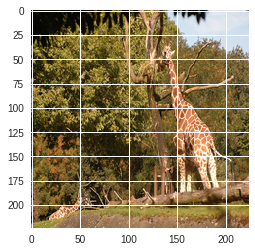

Predicted caption:
 a                                                          

True captions:
A giraffe eating food from the top of the tree.
A giraffe standing up nearby a tree 
A giraffe mother with its baby in the forest.
Two giraffes standing in a tree filled area.
A giraffe standing next to a forest filled with trees.


In [0]:
generate_caption_coco(idx=1, train=True)


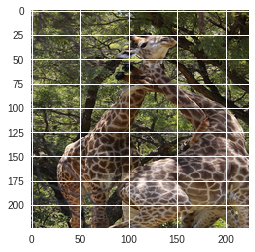

Predicted caption:
 a                                                          

True captions:
A couple of giraffe snuggling each other in a forest.
A couple of giraffe standing next to some trees.
Two Zebras seem to be embracing in the wild. 
Two giraffes hang out near trees and nuzzle up to each other.
The two giraffes appear to be hugging each other.


In [0]:
generate_caption_coco(idx=10, train=True)